In [1]:
from datasets import load_dataset
import torch
from pydvl.influence.torch import EkfacInfluence

imdb = load_dataset("imdb")

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset imdb (/Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 378.50it/s]


In [2]:
small_train_dataset = (
    imdb["train"].shuffle(seed=42).select([i for i in list(range(10))])
)
small_test_dataset = imdb["test"].shuffle(seed=4).select([i for i in list(range(5))])

Loading cached shuffled indices for dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-9c48ce5d173413c7.arrow
Loading cached shuffled indices for dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-d00218895ddb9236.arrow


In [3]:
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("assemblyai/distilbert-base-uncased-sst2")
model = AutoModelForSequenceClassification.from_pretrained(
    "assemblyai/distilbert-base-uncased-sst2"
)

tokenized_segments = tokenizer(
    ["Pydvl is the best data valuation library, and it is fully open-source!"],
    return_tensors="pt",
    padding=True,
    truncation=True,
)
tokenized_segments_input_ids, tokenized_segments_attention_mask = (
    tokenized_segments.input_ids,
    tokenized_segments.attention_mask,
)
model_predictions = F.softmax(
    model(
        input_ids=tokenized_segments_input_ids,
        attention_mask=tokenized_segments_attention_mask,
    )["logits"],
    dim=1,
)

print("Positive probability: " + str(model_predictions[0][1].item() * 100) + "%")
print("Negative probability: " + str(model_predictions[0][0].item() * 100) + "%")

Positive probability: 99.57591891288757%
Negative probability: 0.42408257722854614%


In [4]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)


tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

Loading cached processed dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-e2c3a4e5d7ae70bc.arrow


Loading cached processed dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-f11a8e18a76ea3e7.arrow


In [5]:
class ImdbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, attn_mask, labels):
        self.encodings = encodings
        self.attn_mask = attn_mask
        self.labels = labels

    def __getitem__(self, idx):
        x = torch.tensor([self.encodings[idx], self.attn_mask[idx]])
        y = torch.tensor(self.labels[idx])
        return x, y

    def __len__(self):
        return len(self.labels)

In [6]:
train_dataset = ImdbDataset(
    tokenized_train["input_ids"],
    tokenized_train["attention_mask"],
    tokenized_train["label"],
)
test_dataset = ImdbDataset(
    tokenized_test["input_ids"],
    tokenized_test["attention_mask"],
    tokenized_test["label"],
)

In [7]:
class PatchedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x[:, 0], x[:, 1])["logits"]

In [8]:
for param in model.named_parameters():
    param[1].requires_grad = False

for m_name, module in model.named_modules():
    if len(list(module.children())) == 0 and len(list(module.parameters())) > 0:
        if isinstance(module, torch.nn.Linear):
            for p_name, param in module.named_parameters():
                if (
                    "ffn" in m_name
                    or "pre_classifier" in m_name
                    or "classifier" in m_name
                ):
                    param.requires_grad = True

In [9]:
for param in model.named_parameters():
    if param[1].requires_grad:
        print(param[0], param[1].shape)

distilbert.transformer.layer.0.ffn.lin1.weight torch.Size([3072, 768])
distilbert.transformer.layer.0.ffn.lin1.bias torch.Size([3072])
distilbert.transformer.layer.0.ffn.lin2.weight torch.Size([768, 3072])
distilbert.transformer.layer.0.ffn.lin2.bias torch.Size([768])
distilbert.transformer.layer.1.ffn.lin1.weight torch.Size([3072, 768])
distilbert.transformer.layer.1.ffn.lin1.bias torch.Size([3072])
distilbert.transformer.layer.1.ffn.lin2.weight torch.Size([768, 3072])
distilbert.transformer.layer.1.ffn.lin2.bias torch.Size([768])
distilbert.transformer.layer.2.ffn.lin1.weight torch.Size([3072, 768])
distilbert.transformer.layer.2.ffn.lin1.bias torch.Size([3072])
distilbert.transformer.layer.2.ffn.lin2.weight torch.Size([768, 3072])
distilbert.transformer.layer.2.ffn.lin2.bias torch.Size([768])
distilbert.transformer.layer.3.ffn.lin1.weight torch.Size([3072, 768])
distilbert.transformer.layer.3.ffn.lin1.bias torch.Size([3072])
distilbert.transformer.layer.3.ffn.lin2.weight torch.Size(

In [10]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=5, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=3, shuffle=True)

In [11]:
patched_model = PatchedModel(model)
patched_model.eval()

ekfac_influence_model = EkfacInfluence(
    patched_model,
    progress=True,
)
ekfac_influence_model = ekfac_influence_model.fit(train_dataloader)
# ekfac_influence_model.update_diag(train_dataloader)

K-FAC blocks: 100%|██████████| 2/2 [00:10<00:00,  5.09s/it]


In [31]:
first_test_batch = next(iter(test_dataloader))
first_train_batch = next(iter(train_dataloader))

In [91]:
influences_by_reg_value = ekfac_influence_model.explore_hessian_regularization(
    *first_train_batch, regularization_values=[1e-9, 1e-7, 1e-5, 100]
)

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/transformers/models/distilbert/modeling_distilbert.py:222: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::masked_fill.Tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  scores = scores.masked_fill(


In [92]:
import pandas as pd

cols = ["reg_value", "layer_id", "mean_infl"]
infl_df = pd.DataFrame(influences_by_reg_value, columns=cols)
for reg_value in influences_by_reg_value:
    for layer_id, layer_influences in influences_by_reg_value[reg_value].items():
        mean_infl = torch.mean(layer_influences, dim=0).detach().numpy()
        infl_df = pd.concat(
            [infl_df, pd.DataFrame([[reg_value, layer_id, mean_infl]], columns=cols)]
        )

In [93]:
from scipy.stats import pearsonr, spearmanr

for layer_id, group_df in infl_df.groupby("layer_id"):
    print("Layer", layer_id)
    for idx, mean_infl in enumerate(group_df["mean_infl"]):
        if idx == 0:
            continue
        print("Reg value", group_df["reg_value"].iloc[idx])
        print(
            "Pearson",
            pearsonr(mean_infl, group_df["mean_infl"].iloc[idx - 1]).statistic,
        )
        print(
            "Spearman",
            spearmanr(mean_infl, group_df["mean_infl"].iloc[idx - 1]).statistic,
        )

Layer model.classifier
Reg value 1e-07
Pearson 0.9999999999982297
Spearman 0.9999999999999999
Reg value 1e-05
Pearson 0.9999999999198821
Spearman 0.9999999999999999
Reg value 100.0
Pearson 0.9890089520584947
Spearman 0.8999999999999998
Layer model.distilbert.transformer.layer.0.ffn.lin1
Reg value 1e-07
Pearson 0.9999619048425001
Spearman 0.9999999999999999
Reg value 1e-05
Pearson 0.9987266503875496
Spearman 0.9999999999999999
Reg value 100.0
Pearson 0.9774404060098946
Spearman 0.8999999999999998
Layer model.distilbert.transformer.layer.0.ffn.lin2
Reg value 1e-07
Pearson 0.9999336542986618
Spearman 0.9999999999999999
Reg value 1e-05
Pearson 0.9990544073004429
Spearman 0.9999999999999999
Reg value 100.0
Pearson 0.9976124885796617
Spearman 0.8999999999999998
Layer model.distilbert.transformer.layer.1.ffn.lin1
Reg value 1e-07
Pearson 0.9999533857529216
Spearman 0.9999999999999999
Reg value 1e-05
Pearson 0.9989482437845721
Spearman 0.9999999999999999
Reg value 100.0
Pearson 0.99649140078882

In [13]:
first_train_batch[1][0] = 1 - first_train_batch[1][0]

In [14]:
ekfac_train_influences = ekfac_influence_model.influences(
    *first_test_batch, *first_train_batch, mode="up"
)

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/transformers/models/distilbert/modeling_distilbert.py:222: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::masked_fill.Tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  scores = scores.masked_fill(


In [15]:
ekfac_train_influences

tensor([[ 3.2714e+01,  2.1226e+02, -3.1409e+00, -8.7363e+01,  3.4665e+02],
        [-2.8046e+02,  2.0380e+02, -6.3348e-01, -3.5344e+01,  1.5909e+02],
        [-8.7853e-01, -4.7143e+00,  2.3439e-01,  1.0359e+00, -5.3958e+00]])

In [16]:
torch.mean(ekfac_train_influences, axis=0)

tensor([-82.8759, 137.1154,  -1.1800, -40.5570, 166.7804])

In [17]:
ekfac_train_influences[0][0]

tensor(32.7142)

In [18]:
torch.mean(ekfac_train_influences[0])

tensor(100.2229)

In [19]:
ekfac_train_influences.shape

torch.Size([3, 5])

In [20]:
ekfac_train_influences = ekfac_influence_model.influences_by_layer(
    *first_test_batch, *first_train_batch, mode="up"
)

In [21]:
influences = torch.zeros(size=(3, 5))
for layer_id, value in ekfac_train_influences.items():
    influences += value

In [26]:
idx = (0, 2)
infl_across_layers = []
for layer_id, value in ekfac_train_influences.items():
    infl_across_layers.append(value[idx].item())

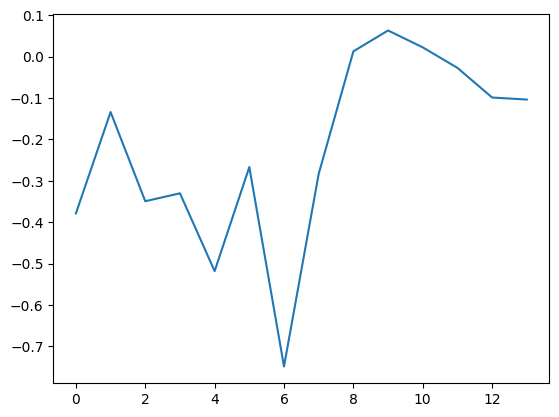

In [27]:
import matplotlib.pyplot as plt

plt.plot(infl_across_layers)